# Notebook to segment cells

In [1]:
from os import listdir; from os.path import isfile, join
import re  
from scipy import ndimage
import trackpy as tp
tp.quiet() 
from cellpose import models
from matplotlib import gridspec
import math
import seaborn as sn                       
from numpy import unravel_index
from skimage import morphology
import numpy as np 
import pandas as pd#
import pathlib
import sys
import matplotlib.pyplot as plt 


In [2]:
# loading main directories  
current_dir = pathlib.Path().absolute()
rsnaped_dir = current_dir.parents[0].joinpath('rsnaped')
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [3]:
# List all video in dir
def read_files_in_directory(video_dir):
    list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
    print(path_files)
    return path_files


In [4]:
case = 1
if case == 0:
    selected_video = 1 # 0-2
    video_dir = current_dir.parents[0].joinpath('DataBases','moving_cells')
    path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
    image_optimization = list_videos[selected_video] 
    
elif case == 1:
    selected_video = 0 # 0 is the only move with multiple cells
    video_dir = current_dir.parents[0].joinpath('/home/luisub/Desktop/rsnaped/DataBases/KDM5B_Translation_SampleMovies')
    path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
    image_optimization = list_videos[selected_video] 
    image_optimization = rsp.ConvertToStandardFormat(video=image_optimization, time_position = 0, height_position = 2,  width_position = 3, channel_position = 1 ).transpose_video()
    image_optimization = image_optimization[:,:,:,1]
    
elif case == 2:
    selected_video = 1 # 0-4
    video_dir = current_dir.parents[0].joinpath('DataBases','Jacks_Data')
    path_files, list_files_paths, list_videos, num_videos = rsp.Utilities.read_files_in_directory(directory=video_dir, extension_of_files_to_look_for = 'tif',return_images_in_list=True)
    image_optimization = list_videos[0][:,selected_video,:,:]
    
# Print the shape of the video
print(image_optimization.shape)
print(np.max(image_optimization))



The video has been transposed to the format [T, Y, X, C] and the channels are RGB
(300, 512, 512)
18792


# Functions

In [5]:
def plot_all_images(video, number_columns=15,df_cells_location=None,cmap_selected='tab20'):
    number_images = video.shape[0]
    number_rows = math.ceil(number_images/number_columns)
    individual_figure_size = 2
    # Loop to plot multiple cells in a grid
    gs = gridspec.GridSpec(number_rows, number_columns)
    gs.update(wspace = 0.1, hspace = 0.1) # set the spacing between axes.
    fig = plt.figure(figsize = (individual_figure_size*number_columns, individual_figure_size*number_rows))
    if len(video.shape) == 4:
        video = video[:,:,:,0]  # removing the channel dimension
    for index_image in range(0, number_images):
        if not df_cells_location is None:
            all_cell_ids_labels = df_cells_location.particle.unique()
            df_for_time_point = df_cells_location.loc[df_cells_location['frame'] == index_image]
            cell_ids_labels = df_for_time_point.particle.unique()
            # section that replaces some pixels to show the cell id at the same color for all time points
            for j in (all_cell_ids_labels):
                video[index_image,0,j]=j
            ax = fig.add_subplot(gs[index_image])
            ax.imshow(video[index_image,:,:], cmap = 'tab20')
            for _, label in enumerate(cell_ids_labels):
                cell_idx_string = str(label)
                Y_cell_location = df_for_time_point.loc[df_for_time_point['particle'] == label, 'y'].item()
                X_cell_location = df_for_time_point.loc[df_for_time_point['particle'] == label, 'x'].item()
                ax.text(x=X_cell_location, y=Y_cell_location, s=cell_idx_string, fontsize=12, color='black')
        else:
            ax = fig.add_subplot(gs[index_image])
            ax.imshow(video[index_image,:,:], cmap = cmap_selected)
        ax.set_xticks([]); ax.set_yticks([])
    plt.show()
    


In [6]:
def reorder_particles(dataframe):
    unique_particles = dataframe['particle'].unique()
    particle_dict = {particle: index+1 for index, particle in enumerate(unique_particles)}
    dataframe['particle'] = dataframe['particle'].map(particle_dict)
    return dataframe

In [7]:
def cells_center_of_mass(list_masks_for_all_frames):
    # Creating dataframe with centers of mass
    list_df=[]
    number_frames= list_masks_for_all_frames.shape[0]
    for i in range(number_frames):
        number_cells_in_frame = list_masks_for_all_frames[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(list_masks_for_all_frames[i]==m,1,0) # Selecting only one mask.  
            x,y = ndimage.measurements.center_of_mass(selected_mask)
            list_df.append( [i,int(x),int(y)] )
            del x, y, selected_mask
    return np.array(list_df)

In [8]:
def convert_mask_labels (masks,tracking_dataframe):
    number_frames= masks.shape[0]
    list_new_masks= []
    for i in range(0,number_frames):
        # creating a copy of the original image
        temp_image = np.zeros_like(masks[0,:,:])
        trackpy_labels = tracking_dataframe.loc[tracking_dataframe['frame']==i ].particle.values
        # Iterate for each cell in 
        number_cells_in_frame = masks[i].max()
        for m in range (1, number_cells_in_frame+1):
            selected_mask = np.where(masks[i]==m,1,0) # Selecting only one mask.  
            for _, particle_label in enumerate (trackpy_labels):
                # Test if the center of mass is inside the selected mask 
                y, x = tracking_dataframe.loc[(tracking_dataframe['frame']==i ) & (tracking_dataframe['particle']==particle_label) , ['y', 'x']].values[0]
                if selected_mask[y,x]==1:
                    temp_image = np.where(selected_mask==1, particle_label,temp_image)
        list_new_masks.append(temp_image)
    return np.array(list_new_masks)

In [9]:
def remove_small_masks(masks,MIN_CELL_SIZE = 2000):
    reorder_masks=np.zeros_like(masks)
    for i,mask in enumerate(masks):
        filtered_labels = morphology.remove_small_objects(mask, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_nuclei = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_nuclei[filtered_labels == old_label] = idx
        reorder_masks[i]=tested_masks_nuclei
    return reorder_masks

In [10]:
# optimization code to detected cells using multiple intensity thresholds
def cell_segmentation_optimized (image_to_segment,model,cell_size=100,max_percentile=99,minimal_trajectory_length= 5, masks_with_trackpy_labels= False, max_time_points=None): 
    temp_image = image_to_segment.copy()
    if max_time_points is not None:
        max_range_to_evaluate = np.min((max_time_points, temp_image.shape[0]))
        temp_image = temp_image[:max_range_to_evaluate,:,:]
    image_to_segment =rsp.RemoveExtrema(temp_image, min_percentile = 0.1, max_percentile = max_percentile,format_video = 'TYX').remove_outliers()
    list_image_test = [image_to_segment[i] for i in range(image_to_segment.shape[0])]
    masks_for_all_frames, _, _, _ = model.eval(list_image_test, diameter=cell_size, min_size=500, channels=[0,0], net_avg=False, augment=True,flow_threshold=1)
    if masks_for_all_frames not in [None,[]]:
        masks_for_all_frames =remove_small_masks(masks_for_all_frames)
        array_center_mass = cells_center_of_mass(masks_for_all_frames)
        df = pd.DataFrame(array_center_mass, columns=['frame', 'y', 'x'])
        try:
            t = tp.link(df, memory=1,search_range=70)
            t_filtered = tp.filter_stubs(t, minimal_trajectory_length)  # selecting trajectories that appear in at least 10 frames.
            t_filtered = reorder_particles(t_filtered)
            num_detected_cells = t_filtered['particle'].nunique()
        except:
            num_detected_cells = 0
            t_filtered = pd.DataFrame([], columns=['frame', 'y', 'x'])
        if (masks_with_trackpy_labels == True) and (num_detected_cells>0) :
            masks= convert_mask_labels (masks=masks_for_all_frames,tracking_dataframe=t_filtered)
        else:
            masks= masks_for_all_frames
    else:
        num_detected_cells = 0
        masks = None
        t_filtered = pd.DataFrame([], columns=['frame', 'y', 'x'])
    return num_detected_cells, masks, t_filtered

# Running codes

In [11]:
number_optimization_steps = 3
int_threshold_vector = np.linspace(95,99, num=number_optimization_steps, endpoint=True,dtype=int)
cell_size_vector = np.linspace(150,300, num=number_optimization_steps, endpoint=True,dtype=int)
model = models.Cellpose(gpu=True, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
print(int_threshold_vector)
print(cell_size_vector)

[95 97 99]
[150 225 300]


In [12]:
# Optimization code
detected_cells_matrix = np.zeros((int_threshold_vector.shape[0],cell_size_vector.shape[0] ) )
for index_intensity, intensity_value in enumerate(int_threshold_vector):
    for index_cell_size, cell_size in enumerate(cell_size_vector):
        detected_cells_matrix[index_intensity,index_cell_size],_,_ = cell_segmentation_optimized (image_to_segment=image_optimization,model=model,
                                                                                                  cell_size=cell_size, 
                                                                                                  max_percentile=intensity_value,
                                                                                                  minimal_trajectory_length = 10,
                                                                                                  max_time_points=20)

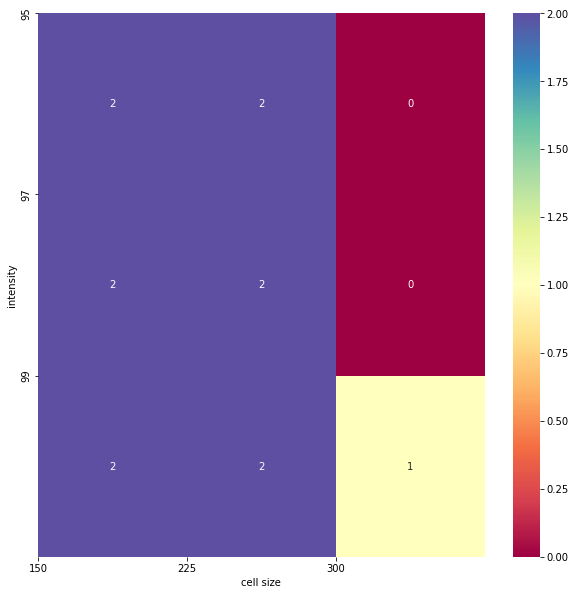

In [13]:
# showing optimization plot
tick_values= np.linspace(0, number_optimization_steps,num=number_optimization_steps,endpoint=False)
df_optimization = pd.DataFrame(detected_cells_matrix ) # Converting the image into a pandas data frame
fig, ax = plt.subplots(1,1,figsize=(10,10))
sn.heatmap(df_optimization, annot=True,cmap="Spectral",ax=ax)
ax.set_xlabel('cell size')
ax.set_ylabel('intensity')
ax.set_yticks(tick_values,int_threshold_vector)  
ax.set_xticks(tick_values,cell_size_vector)
plt.show()

In [14]:
# Optimization code
# detected_cells_array = np.zeros((cell_size_vector.shape[0] ) )
# for index_cell_size, cell_size in enumerate(cell_size_vector):
#     detected_cells_array[index_cell_size],_,_ = cell_segmentation_optimized (image_to_segment=image_optimization,model=model,cell_size=cell_size)
# plt.plot(cell_size_vector,detected_cells_array)
# plt.title("Detected Cells")
# plt.xlabel("Cell Size")
# plt.ylabel("Number of Detected Cells")
# plt.grid(True)
# plt.show()

## Running the code with the selected parameters

In [15]:
# running for selected values
selected_intensity_index, selected_cell_size_index = unravel_index(detected_cells_matrix.argmax(), detected_cells_matrix.shape)
selected_cell_size = cell_size_vector[selected_cell_size_index] 
selected_intensity_value = int_threshold_vector[selected_intensity_index]
num_detected_cells, masks_final, df_cells_location = cell_segmentation_optimized (image_to_segment=image_optimization,
                                                                                model=model,
                                                                                cell_size=selected_cell_size, 
                                                                                max_percentile=selected_intensity_value, 
                                                                                minimal_trajectory_length = 10,   
                                                                                masks_with_trackpy_labels= True)


In [16]:
print("Number of detected cells: ", num_detected_cells)
print("Selected intensity value: ", selected_intensity_value)
print("Selected cell size: ", selected_cell_size)   

Number of detected cells:  2
Selected intensity value:  95
Selected cell size:  150


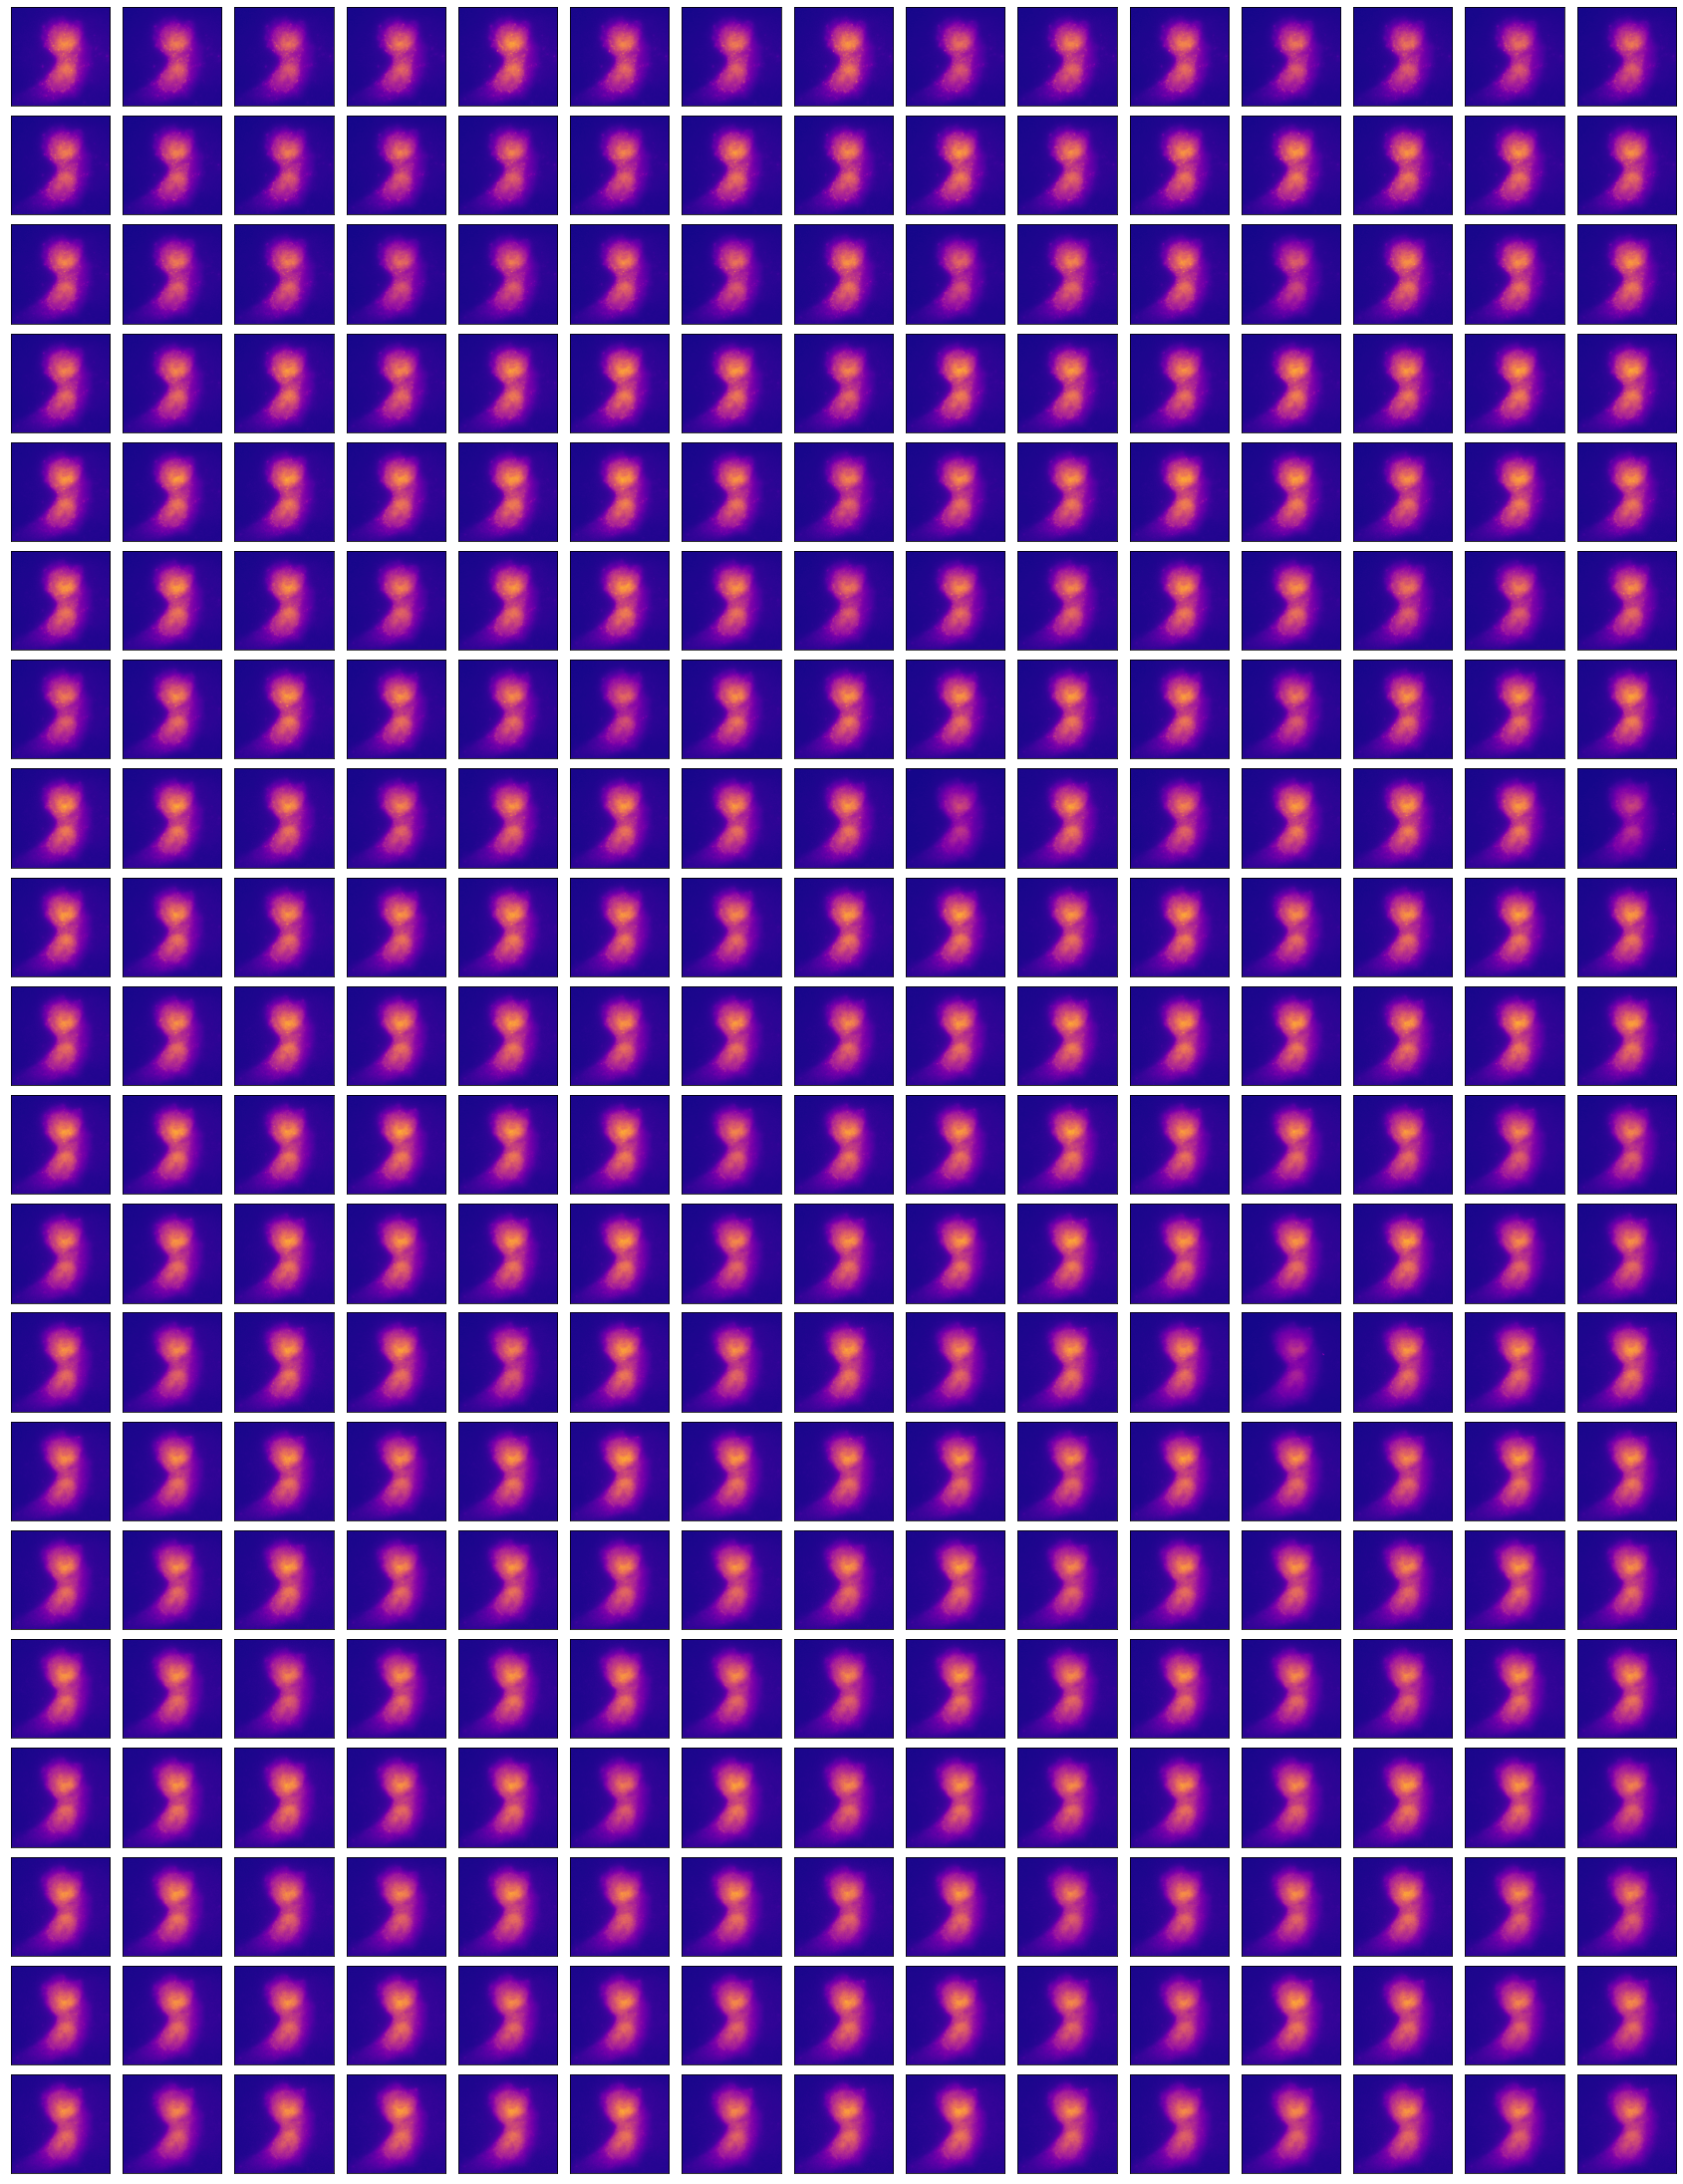

In [17]:
plot_all_images(video=image_optimization, number_columns=15,cmap_selected='plasma')

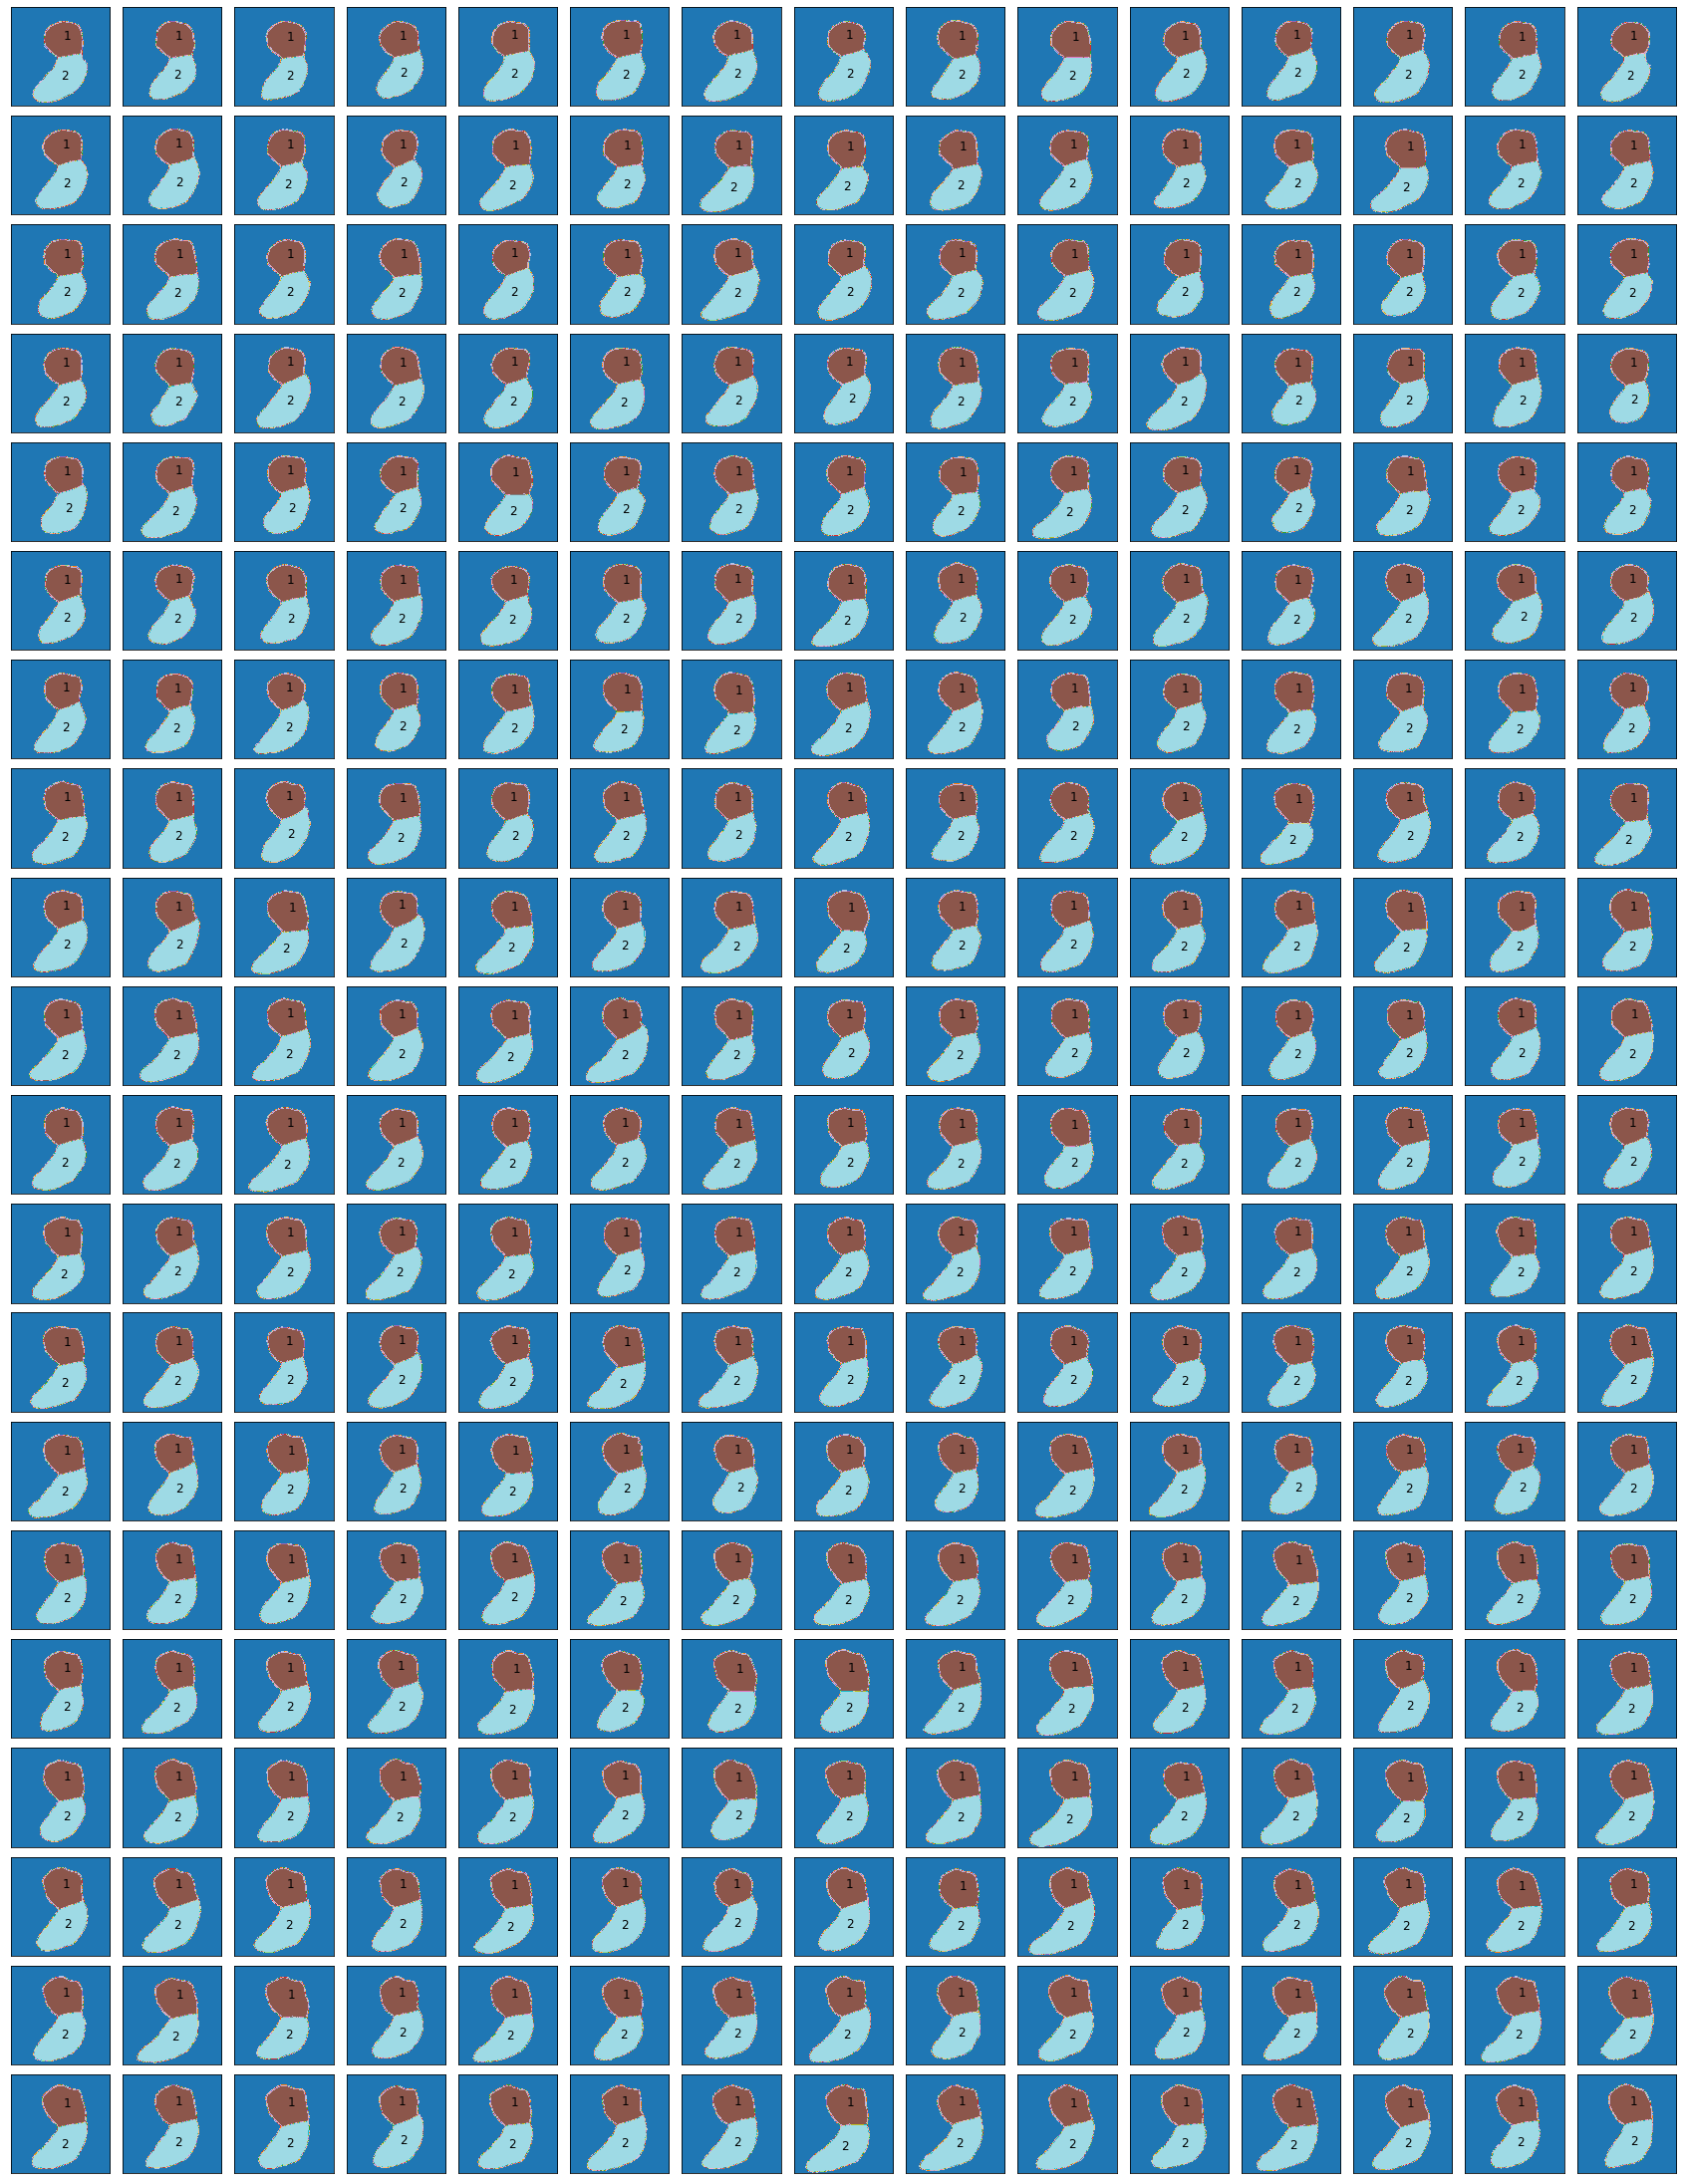

In [18]:
# Plotting the selected masks
plot_all_images(video=masks_final, number_columns=15,df_cells_location=df_cells_location)

In [19]:
# Create another function that creates a constant mask for all time points. That is the cells are detected in the first frame and then the mask is propagated to all time points.


In [20]:
# 

In [21]:
# all_cell_ids_labels = df_cells_location.particle.unique()
# for i,mask in enumerate(masks_final):
#     df_for_time_point = df_cells_location.loc[df_cells_location['frame'] == i]
#     cell_ids_labels = df_for_time_point.particle.unique()
#     # section that replaces some pixels to show the cell id at the same color for all time points
#     for j in (all_cell_ids_labels):
#         mask[0,j]=j
#     plt.imshow(mask, cmap = 'tab20')
    
#     for _, label in enumerate(cell_ids_labels):
#         cell_idx_string = str(label)
#         Y_cell_location = df_for_time_point.loc[df_for_time_point['particle'] == label, 'y'].item()
#         X_cell_location = df_for_time_point.loc[df_for_time_point['particle'] == label, 'x'].item()
#         plt.text(x=X_cell_location, y=Y_cell_location, s=cell_idx_string, fontsize=12, color='black')
    
#     plt.show()
#     print(np.unique(mask))